In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn

import warnings
warnings.filterwarnings('ignore')

### Data Processing & Feature Extraction
1. analysis of correlation in respect to target
2. LDA analysis to indication good separability 
3. represent the samples with a new feature vector


correlation to target:
 fbs         0.028046
chol        0.085239
restecg     0.137230
trestbps    0.144931
age         0.225439
sex         0.280937
thal        0.344029
slope       0.345877
ca          0.391724
thalach     0.421741
oldpeak     0.430696
cp          0.433798
exang       0.436757
target      1.000000
Name: target, dtype: float64 



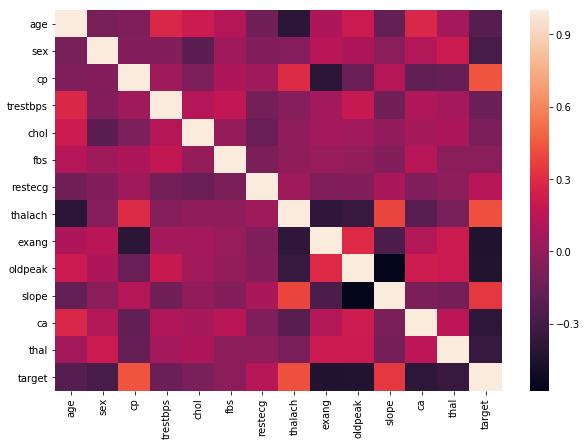

In [2]:
# 1. ANALYSIS OF CORRELATION
data_url = 'https://gitlab.com/yuxuan.chen/storage/'\
    '-/raw/master/IPADS-2019/week1/heart.csv'
data = pd.read_csv(data_url)

corr = data.corr()['target'].abs().sort_values()
print('\ncorrelation to target:\n', corr, '\n')

# plot heatmap of correlation
plt.figure(figsize=(10,7))
seaborn.heatmap(data.corr())

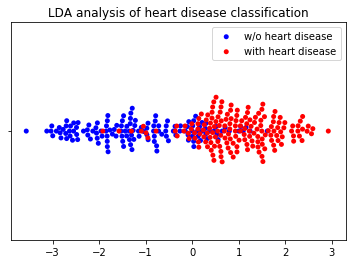

In [3]:
# 2. LDA ANALYSIS
clf = LDA(n_components=1)
y = data['target'].values
X = clf.fit(data[data.columns[:-1]].values, y).\
    transform(data[data.columns[:-1]].values)
X = X[:, 0]

seaborn.swarmplot(X[y == 0], color='b', label='w/o heart disease')
seaborn.swarmplot(X[y == 1], color='r', label='with heart disease')
plt.title('LDA analysis of heart disease classification')
plt.legend()

In [4]:
# 3. REPRESENT WITH NEW FEATURE VECTORS
# one-hot encoding function
def onehot(series, num_classes=None):
    if num_classes == None:
        num_classes = len(np.unique(series))
    # return an itentical matrix with each slice encoding an attribute    
    return np.identity(num_classes)[series]

# keep no-need-re-encode column as the same
need_encode_col = ['restecg', 'thal', 'slope', 'cp']
no_encode_col = [col for col in data.columns if col not in need_encode_col]
new_data = data[no_encode_col]

In [5]:
# append the new encoding of desired columns
for col in need_encode_col:
    num_classes = len(data[col].unique())
    new_col_names = [f'{col}_{i}' for i in range(num_classes)]
    encoded = pd.DataFrame(data=onehot(data[col], num_classes),
                           columns=new_col_names,
                           dtype=int)
    new_data = pd.concat([new_data, encoded], axis=1)

#### Train a Neural Network for Classification
1. partition into train & valid & test set 
2. build a 3-layer neural network
3. train the NN and velidate every {log_inteval} epochs
4. use the model on the test set and see the result

In [6]:
# 1. PARTITION INTO TRAIN & VALID & TEST
data_cols = [col for col in new_data.columns if col != 'target']
new_data_shuffled = shuffle(new_data, random_state=443)
X = new_data_shuffled[data_cols].values
y = new_data_shuffled['target'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=21)
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.25, random_state=80)

In [7]:
# 2. BUILD A 3-LAYER NETWORK
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set hyperparameters
num_epochs = 5000
hidden_size = 256
output_size = 1
log_inteval = 250
losses = []
val_losses = []
lr = 1e-4
lr_decay_inteval = 2500
lr_decay_rate = 0.5

In [8]:
# model building: (take the default settings as example)
#     input layer linear(23,80) -> relu + dropout -> 
#     hiddien layer linear(80, 256) -> relu + dropout ->
#     output layer linaer(256, 1) 
model = nn.Sequential(
    nn.Linear(len(data_cols), hidden_size),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(hidden_size, output_size))

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=lr)

# param-initialization for linear layers
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight, 0.06)
model.apply(init_normal)

Sequential(
  (0): Linear(in_features=23, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.6)
  (6): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
# 3. TRAIN & TEST
for epoch in range(1, num_epochs + 1):
    # forward pass
    pred = model(torch.tensor(X_train, dtype=torch.float))
    pred = torch.sigmoid(pred)
    loss = criterion(pred[:, 0], torch.tensor(y_train, dtype=torch.float))    
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % log_inteval == 0: # Logging
        epochs_ran = epoch
        model.eval()
        with torch.no_grad():
            pred = model(torch.tensor(X_test, dtype=torch.float))
            pred = torch.sigmoid(pred)
            val_loss = criterion(pred[:, 0],
                                 torch.tensor(y_test, dtype=torch.float))
            val_losses.append(val_loss.item())
        
        model.train()
        print('total loss in epoch {} = {:.4f},'\
            'validation loss = {:.4f},'.format(epoch, val_loss))
            
        # early stop
        if len(val_losses) > 3 \
               and val_loss.item() > val_losses[-2] \
               and val_loss.item() > val_losses[-3]:
            print('Validation loss not improving, stopping...')
            break

total loss in epoch 250 = 0.4720,                 validation loss = 0.5135,                 lr = 1.00e-04
total loss in epoch 500 = 0.3402,                 validation loss = 0.3688,                 lr = 1.00e-04
total loss in epoch 750 = 0.3132,                 validation loss = 0.3628,                 lr = 1.00e-04
total loss in epoch 1000 = 0.3006,                 validation loss = 0.3543,                 lr = 1.00e-04
total loss in epoch 1250 = 0.2839,                 validation loss = 0.3471,                 lr = 1.00e-04
total loss in epoch 1500 = 0.2649,                 validation loss = 0.3298,                 lr = 1.00e-04
total loss in epoch 1750 = 0.2424,                 validation loss = 0.3074,                 lr = 1.00e-04
total loss in epoch 2000 = 0.1976,                 validation loss = 0.2821,                 lr = 1.00e-04
total loss in epoch 2250 = 0.1569,                 validation loss = 0.2598,                 lr = 1.00e-04
total loss in epoch 2500 = 0.1315,      

In [10]:
# 4. TEST AND SEE THE RESULT
with torch.no_grad():
    model.eval()
    pred = model(torch.tensor(X_test, dtype=torch.float))
    pred_label = np.where(pred.numpy() > 0, 1, 0)
    
# get confusion matrix of test set
cm = pd.DataFrame(data=confusion_matrix(y_test, pred_label), 
                  columns=['T', 'F'], 
                  index=['P', 'N'])
print('Accuracy = %.2f%%\n' % 
        ((cm.iloc[1, 1] + cm.iloc[0, 0]) / cm.values.sum() * 100))
print(cm)

Accuracy = 93.44%

    T   F
P  23   4
N   0  34
